In [6]:
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import combinations
import seaborn as sns
from sklearn.decomposition import PCA
random.seed(30)
df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [7]:
df['Year'] = df['Quarter'].str.extract(r'(\d{4})').astype(int)
df['Quarter_Num'] = df['Quarter'].str.extract(r'(Q\d)').replace({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}).astype(int)
df['Quarter_order'] = (df['Year'] - df['Year'].min()) * 4 + (df['Quarter_Num'] - 1)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment,Year,Quarter_Num,Quarter_order
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9,1970,1,0
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5,1970,2,1
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5,1970,3,2
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7,1970,4,3
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1,1971,1,4
...,...,...,...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0,2018,2,193
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3,2018,3,194
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2,2018,4,195
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1,2019,1,196


In [8]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [9]:
def prepare_data_for_regression(df, target_column, covariates, test_size=40):
    """
    Função para dividir os dados entre treino e teste.
    """
    X = df[covariates]
    y = df[target_column]
    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]
    return X_train, X_test, y_train, y_test


def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

df['Quarter'] = df['Quarter'].apply(lambda x: x.to_timestamp())
df.set_index("Quarter", inplace=True)


In [10]:
def find_best_covariates(df, target_column, covariates, test_size=40):
    best_mae = float('inf')
    best_rmse = float('inf')
    best_mase = float('inf')
    best_covariates = []

    results = []  

    for r in range(1, len(covariates) + 1):
        for subset in combinations(covariates, r):
            subset = list(subset)

            X_train, X_test, y_train, y_test = prepare_data_for_regression(df, target_column, subset, test_size)

            model = LinearRegression()
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mase = mean_absolute_scaled_error(y_test, y_pred, y_train)
            
            results.append({
                'Covariates': subset,
                'MAE': mae,
                'RMSE': rmse,
                'MASE': mase,
            })

            if mase < best_mase:
                best_mae = mae
                best_rmse = rmse
                best_mase = mase
                best_covariates = subset

    results_df = pd.DataFrame(results).sort_values(by='MASE').reset_index(drop=True)
    return best_covariates, best_mae, best_rmse, best_mase, results_df

covariates = ["Income", "Production", "Savings", 'Unemployment', 'Quarter_order']
best_covariates, best_mae, best_rmse, best_mase, results_df = find_best_covariates(df, target_column="Consumption", covariates=covariates)


best_covariates, best_mae, best_rmse, best_mase

(['Income', 'Savings', 'Quarter_order'],
 0.09806759679801196,
 0.15254341013745007,
 0.16042087529954585)

In [11]:
def fit_and_plot_regression(df, target_column, covariates):
    """
    Função para ajustar um modelo de regressão linear múltipla e plotar as previsões.
    """
    X_train, X_test, y_train, y_test = prepare_data_for_regression(df, target_column, covariates)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MASE: {mase}")
    print(f"R²: {r2}")

    plt.figure(figsize=(16, 4))
    plt.plot(y_train.index, y_train, label='y_train', color='#0073b3',linestyle='solid')
    plt.plot(y_test.index, y_test, label='y_test', color='#dd930e',linestyle='solid')
    plt.plot(y_test.index, y_pred, label='y_pred', color='#099f74',linestyle='solid')
    plt.xlabel("Time")
    plt.ylabel(target_column)
    plt.title("Multiple Linear Regression Predictions")
    plt.legend()
    plt.show()

### Análise de multicolinearidade

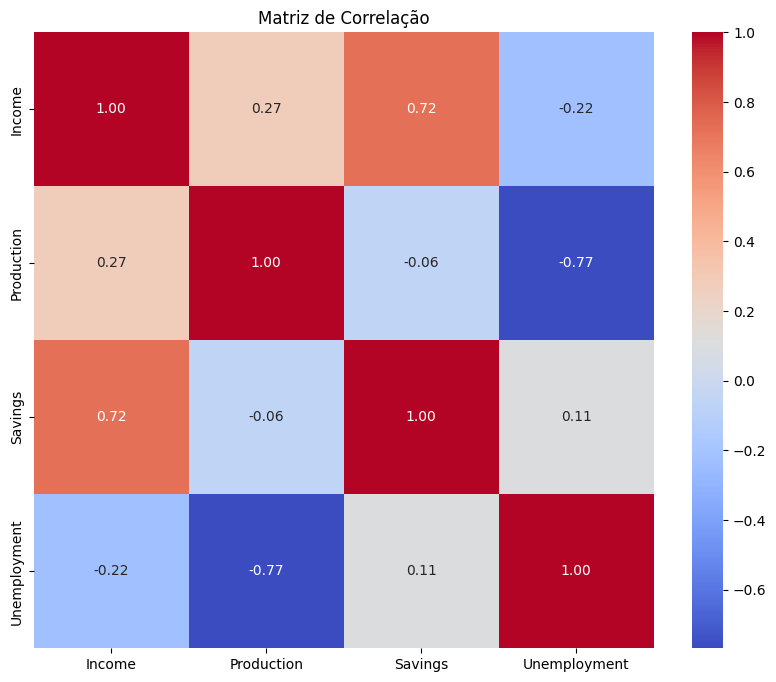

In [12]:
corr_matrix_filtered = df[covariates].drop(columns=["Quarter_order"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_filtered, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

Desemprego possui uma alta colineridade com produção Produção, o que é completamente plausível. Além disso, Savings (poupança) possui colinearidade com a renda, o que também possui sentido. Devemos tomar cuidado na escola das covariáveis para previsão dos resultados, assim não teremos resultados imprecisos.

Primeiro, vamos testar com todas as covariáveis, sem nenhuma transformação aplicada.

MAE: 0.115131447639742
RMSE: 0.14961786029073468
MASE: 0.18833425318775282
R²: 0.7689800958436462


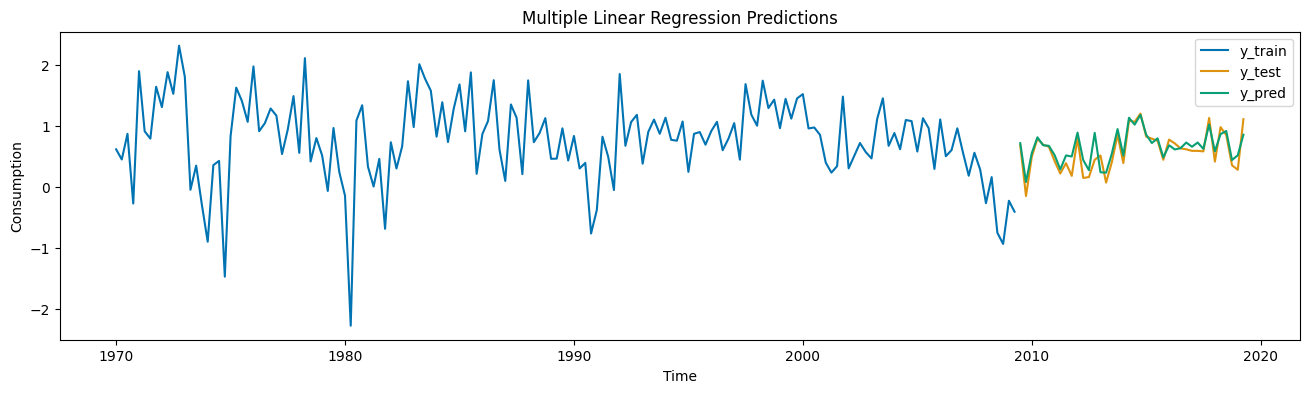

In [13]:
covariates = ["Income", "Production", "Savings", 'Unemployment', 'Quarter_order']

fit_and_plot_regression(df, target_column="Consumption", covariates=covariates)


Agora, selecionaremos as variáveis com melhor métrica ajustada. Curiosamente, essas variáveis são Savings e Income - que possui uma multicolinearidade considerável. Entretanto, isso sugere que ambas possuem informações distintas que o modelo utiliza para as previsões, e podem estar correlacionadas com Consumption de diferentes modos. Se usamos apenas uma delas, o desempenho abaixo consideravelmente.

MAE: 0.09806759679801196
RMSE: 0.15254341013745007
MASE: 0.16042087529954585
R²: 0.7598572818456644


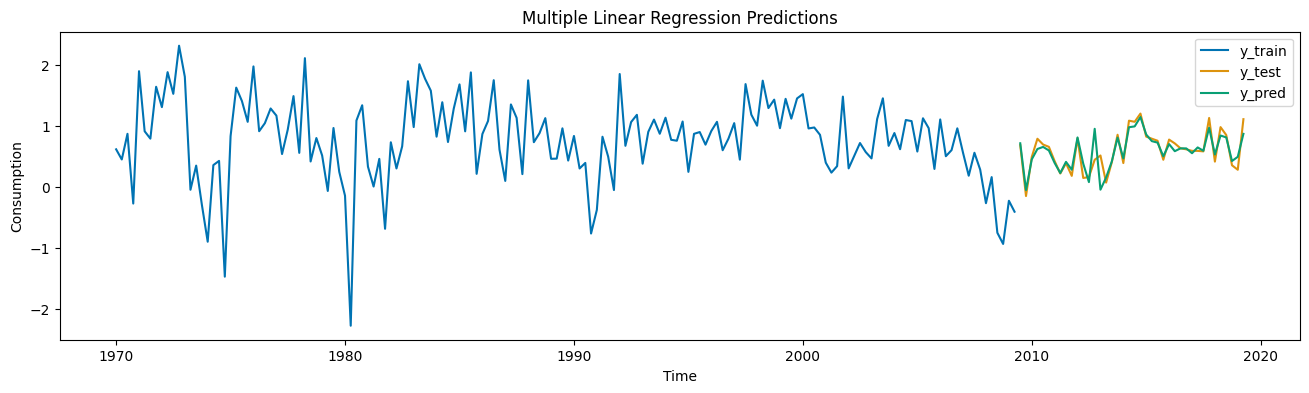

In [14]:
covariates = ["Income", "Savings", 'Quarter_order']

fit_and_plot_regression(df, target_column="Consumption", covariates=covariates)

### Testes de transformação em variáveis

#### Winsorização

MAE: 0.08566361334463968
RMSE: 0.11064657078643643
MASE: 0.14013019878904118
R²: 0.8736548901121275


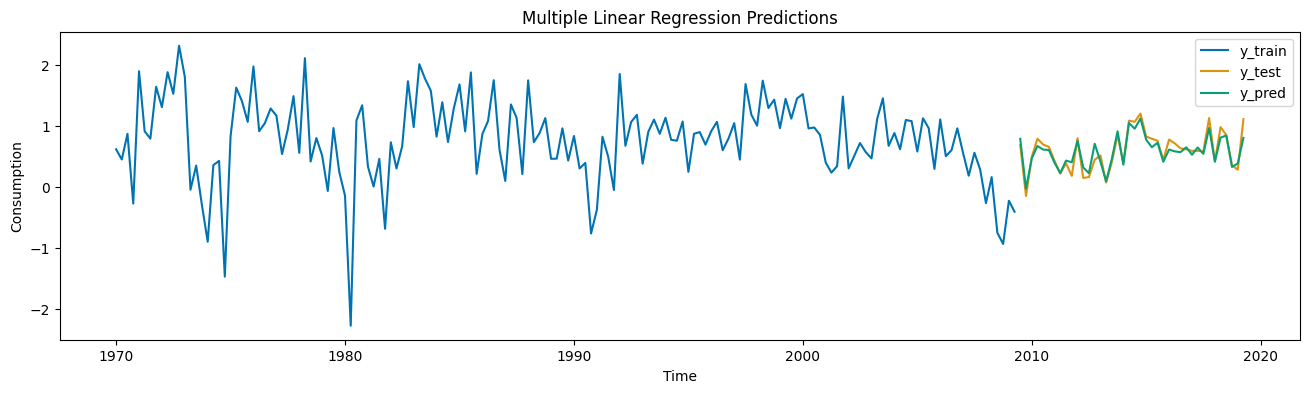

In [15]:
from scipy.stats.mstats import winsorize

df['Savings_winsorized'] = winsorize(df['Savings'], limits=[0.00, 0.03])
covariates = ["Income", "Production", "Savings_winsorized", "Unemployment", "Quarter_order"]
fit_and_plot_regression(df, target_column="Consumption", covariates=covariates)



Testamos a realização de Winsorização, que limita os valores extremos das variáveis. Funciona bem quando limitamos apenas o intervalo superior, o que mostra que o intervalo inferior é essencial para nosso problema.

### Transformações logarítmicas

Testaremos uma transformação logarítmica em Savings, mas é necessário tomar certo cuidado: além dos valores serem positivos e negativos, ambos os extremos são importantes para a predição. Por isso, aplicaremos Log-Sign Transformation, que reduz a escala de valores extremos proporcionalmente e preserva o sinal.

MAE: 0.19751401271982677
RMSE: 0.3492282252864057
MASE: 0.32309724964202013
R²: -0.25863902774877356


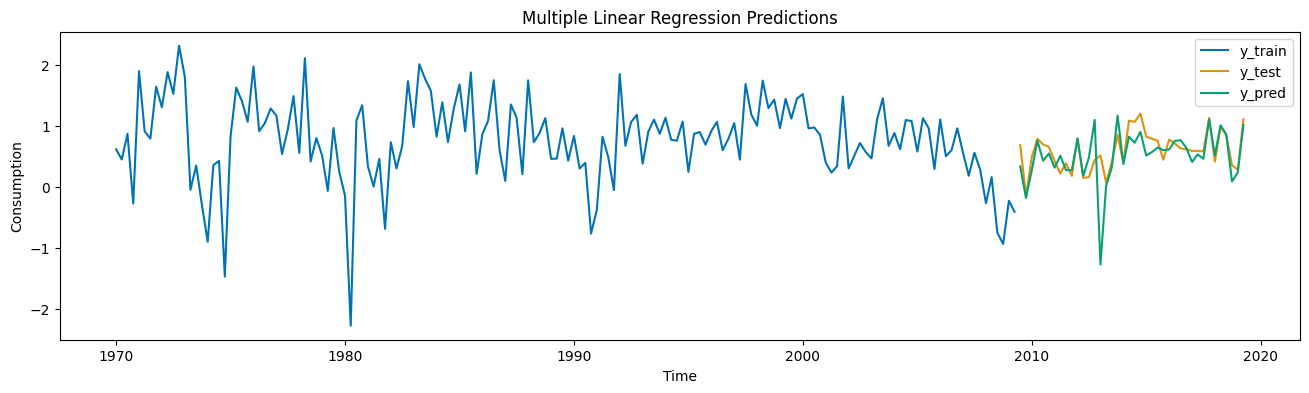

In [16]:
df['Savings_log_sign'] = np.sign(df['Savings']) * np.log(np.abs(df['Savings']) + 1)

covariates = ["Income", "Production", "Savings_log_sign", "Unemployment", "Quarter_order"]

fit_and_plot_regression(df, target_column="Consumption", covariates=covariates)